# Simple 2D motion planning and profile generation for wheeled mobile robots
by Vlad Chira 

## Contents

Motion planning for mobile robots includes at least these very basic steps:   
- Path planning - given a set of points (called knots), we must construct a continuous path that passes through all the points **in the order they were given** in a way that makes the path **traversable** by the robot

    
- Motion profile generation - given a path and the kinematic constraints of a mobile robot, we need to construct *a path-constrained, kinematic-constrained, time-optimal motion profile*   

## Path Planning

In [11]:
import numpy as np
import matplotlib.pyplot as plt

### What is interpolation?

Interpolation is a technique used to estimate values within a set of known data points. It involves creating a function or curve that passes through these data points and then using that function to predict the values at points that lie between the given data points. In essence, interpolation allows us to "fill in the gaps" between the known data points and make *educated guesses* about the values at intermediate positions.   

We'll go over some attempts at doing interpolation for our path planning, explain why some of them don't work and build up to the 'correct' way.

#### Direct polynomial interpolation (and why it is not useful here)

The most intuitive way to interpolate n+1 points is to consider a polynomial of degree n: $f(x) = a_0 + a_1 x + a_2 x^2 + ... + a_n x^n$   
We impose that the function must pass through all n+1 points, which yields n+1 linear equations. So, n+1 equations and n+1 unknowns (the coefficients $a_0, ..., a_n$) create a linear exactly-determined consistent (compatible) system of equations which can be solved for the unknowns.   
Let's look at an example:   
Let the knots be $(1,2) \ ; (2,3) \ ; (4, 7)$. That means $f$ is a second degree polynomial $ f(x) = ax^2 + bx + c $ and $ f(1)=2, f(2)=3, f(4)=7 $. Therefore:   
$$
\left\{\begin{matrix}
a + b + c = 2\\ 
4a + 2b + c = 3\\
16a + 4b + c = 7
\end{matrix}\right.
$$
Solving for the coefficients, we obtain $f(x) = \frac{1}{3}x^2 + \frac{5}{3} $   
Let's plot to check our work

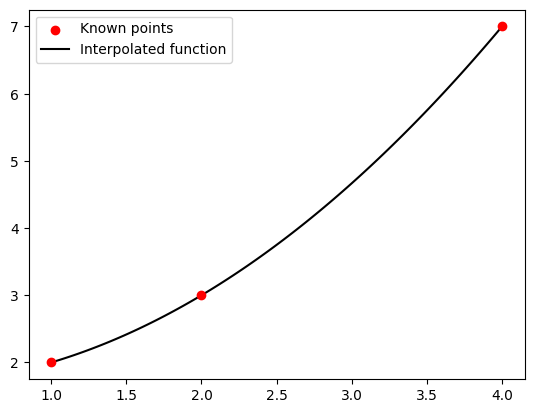

In [12]:
known_x = [1, 2, 4]
known_y = [2, 3, 7]
plt.scatter(known_x, known_y, zorder=10, label='Known points', color='red')

x = np.linspace(1, 4, 100)
y = 1/3*x ** 2 + 5/3
plt.plot(x,y, color='black', label='Interpolated function')

plt.legend()
plt.show()

It looks like it does indeed pass through all the knots.   
Now, let's look at the problems this method has:
1. Numerical instability for many data points   
   If we have 21 points for example, the polynomial must be of degree 20 (or less - depending on the data points, but we assume worst case here), which means raising x to the power of 20. Due to floating point precision errors, the functions will become very numerically instable.
2. Lack of control of the path   
   Once the points are set, the function is unique and cannot be altered (since the system of equations has one and one solution only). Having a flexible and easy to shape path is very important.
3. The points cannot be traversed in a different order
   In the example above, the order of the points seemed to match the function graph, but consider the following: The robot starts at (2,3), moves to (1,2) and then to (4,7). There is no way to accomplish this in our current setup.

#### Point-to-point linear interpolation (and why it can be useful sometimes)

Another approach we might take is to use direct polynomial interpolation between every two adjacent data points. That means one polynomial between each pair of points. Two points means a polynomial of degree 1, in other words straight lines between points.

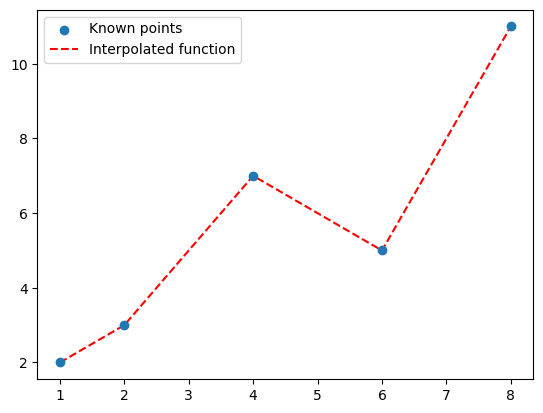

In [13]:
def plot_lines(x, y):
    plt.scatter(x, y, zorder=10, label='Known points')
    # Note: the line below just lets matplotlib handle the linear interpolation
    plt.plot(x, y, color='r', linestyle='dashed', label='Interpolated function')

known_x = [1, 2, 4, 6, 8]
known_y = [2, 3, 7, 5, 11]

plot_lines(known_x, known_y)

plt.legend()
plt.show()

At first glance, this seems to work: the path is continuous, passes through all of the knots and can be traversed in another order simply by changing the order of the points, like this:

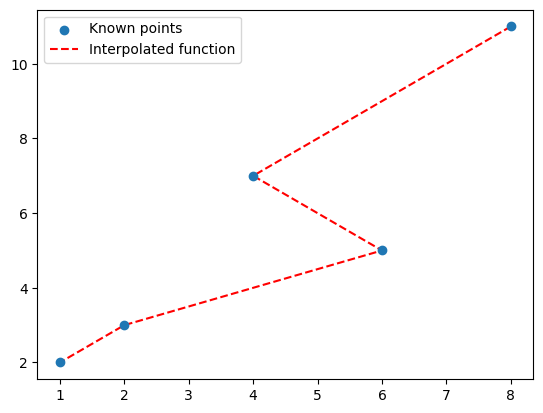

In [14]:
known_x = [8, 4, 6, 2, 1]
known_y = [11, 7, 5, 3, 2]

plot_lines(known_x, known_y)

plt.legend()
plt.show()

The problem is, while this path is continous from a mathematical point of view, the robot cannot traverse it because it creates discontinuities in velocity near the knots. Let's focus on a single knot and its neighbourhood.   

We can imagine the robot is immediately close to reaching the knot, and the velocity vector is tangent to the path.   
Then, we can imagine the robot immediately after the knot, the velocity vector being again, tangent to the path.   
Finally, we could think about the sudden transition between these velocities and how a *real* robot would react to it.

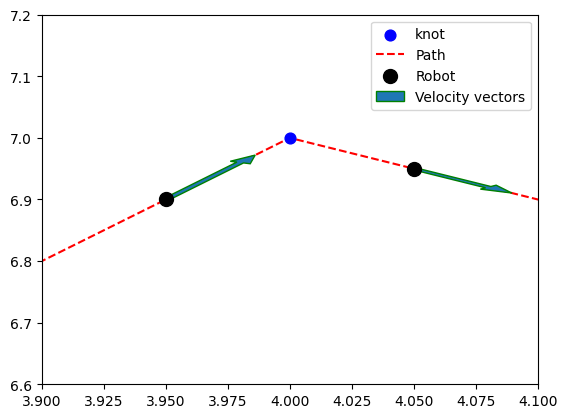

In [15]:
known_x = [2, 4, 6]
known_y = [3, 7, 5]
plt.scatter(4, 7, color='blue', label='knot', zorder=10, s=60)
plt.plot(known_x, known_y, color='r', linestyle='dashed', label='Path')

# Draw the 'robot' before and after
plt.scatter(3.95, 6.9, color='black', zorder=10, s=100, label='Robot')
plt.scatter(4.05, 6.95, color='black', zorder=10, s=100)
# And their 'velocity' vectors
plt.arrow(3.95, 6.9, 0.03, 0.06, width = 0.003, ec ='green', zorder=9, label='Velocity vectors')
plt.arrow(4.05, 6.95, 0.03, -0.03, width = 0.003, ec ='green', zorder=9)

plt.xlim([3.9, 4.1])
plt.ylim([6.6, 7.2])
plt.legend()
plt.show()

Because the velocity vectors are different to the left and to the right of the knot (in the neighborhood, so infinitesimally close to the knot), such a drastic change in velocity equates to very high acceleration (basically infinite), something that our *real* robot cannot possibly archieve.   

So, we conclude that it is impossible to chain together straight lines like this because of discontinuities in the velocity and acceleration. But straight lines can still be useful provided the robot decelerates to a standstill as it reaches the knot and then accelerates again on the next straight line.

#### Splines

Splines are by far the most common way to represent any sort of path or curve in a computer and you have most likely already used splines before (in the Pen Tool of Photoshop, in CAD software etc. ). We were on the right track with the linear interpolation, but instead of interpolating between two points with a line, we use a higher degree polynomial, usually a **cubic polynomial**. Each spline is made up of cubic polynomials that are called **segments**.  
For reasons which I'm not going to go into now (see [1]), for our application we need to go two degrees higher, to **quintic splines**.   

But before, we need to take a detour and understand **parametric curves**.   

(Remember, all we do in this part is construct a segment **between two points**. For more points, we need to chain multiple segments together.)

##### Parametric Curves

There are many ways to draw mathematical curves, but the most common one is with **explicit equations**. All one dimensional real functions are basically explicit equations $y = f(x)$. *Explicit* comes from the fact that one of the variables can be expressed using the other one.   

**Implicit equations** on the other hand, are of the form $R(x_0, x_1, ...) = 0$, where there is no possible way to completely separate the variables. Example: the equation of the unit circle $x^2 + y^2 -1 = 0$

**Parametric equations** are equations which both x and y are dependent on a *parameter*, usually called *t* in some range. The basic idea is that, because each coordinate can vary independently of the other (although they both depend on **t**), it allows for more control over the curve's behavior.   
For example:
$$ \left\{\begin{matrix}
x(t) = 2t(1 + t^2)\\ 
y(t) = 2t^2
\end{matrix}\right. \ , t \in [-1,1]  $$
would create the curve (a special case of the Cissoid of Diocles):

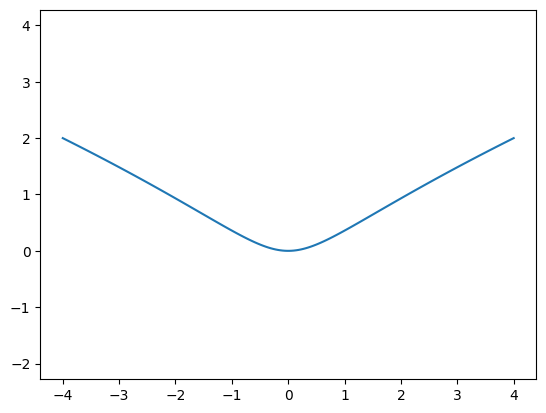

In [16]:
t = np.linspace(-1, 1, 100)
known_x = 2 * t * (1 + t**2)
known_y = 2 * t**2

plt.plot(known_x, known_y)
plt.axis('equal')
plt.show()

#### Quintic Spline Segment

Because of the flexibility that parametric curves have, each segment will be made up of a parametric equation, each coordinate being a polynomial of degree 5 or less. There are n-1 segments making up a spline that interpolates n points. Here is the equation of a single segment with 12 unknowns:
$$
\varphi (t) : \left\{\begin{matrix}
x(t) = a_xt^5 + b_xt^4+c_xt^3+d_xt^2+e_xt + f_x\\ 
y(t) = a_yt^5 + b_yt^4+c_yt^3+d_yt^2+e_yt + f_y
\end{matrix}\right. \ , t \in [0,1]
$$
This however introduces a big problem, the system that was exactly-determined is now underdetermined because we have 2*(n-1) equations but 12*(n-1) unknowns.   
Therefore there are are an infinite number of solutions, meaning an infinite number of segments that can pass through the same two points. Let's plot some curves to check.   
Here are three distinct segments that pass through the same two points. The coefficients aren't just random numbers, the computation part is coming very soon.

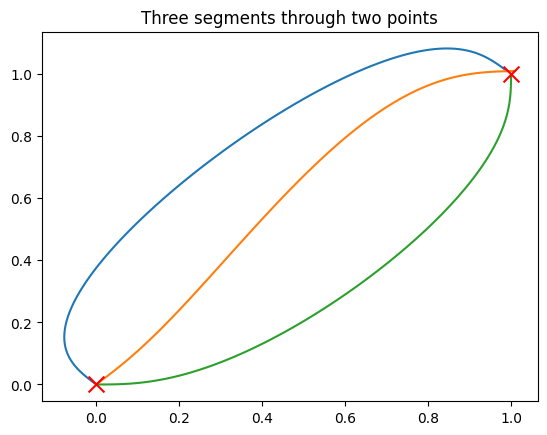

In [17]:
plt.scatter([0, 1], [0, 1], color='red', marker='x', s=130, zorder=10)

t = np.linspace(0, 1, 100)
x1 = -0.71*t + 11.41*t**3 - 15.71*t**4 + 6.0*t**5
y1 = 0.71*t + 8.59*t**3 - 14.29*t**4 + 6.0*t**5

x2 = 0.71*t + 1.76*t**3 - 2.34*t**4 + 0.88*t**5
y2 = 0.71*t + 5.76*t**3 - 9.34*t**4 + 3.88*t**5

x3 = 1.0*t + 4.0*t**3 - 7.0*t**4 + 3.0*t**5
y3 = 6.0*t**3 - 8.0*t**4 + 3.0*t**5

plt.plot(x1, y1)
plt.plot(x2, y2)
plt.plot(x3, y3)
plt.title('Three segments through two points')
plt.show()

So what exactly makes these segments different from each other? The answer: **the first and second derivatives at the knots**.   
We obtain the derivatives of a segment simply by differentiating both x(t) and y(t). Differentiate again and we get the second derivative.
$$
\varphi' (t) : \left\{\begin{matrix}
x'(t) = 5a_xt^4 + 4b_xt^3+3c_xt^2+2d_xt+e_x\\ 
y'(t) = 5a_yt^4 + 4b_yt^3+3c_yt^2+2d_yt+e_y
\end{matrix}\right. \ , t \in [0,1]
$$
The first derivative is simple to visualize and understand. For functions, the first derivative was the slope of the line tangent to the function at a particular point. For parametric equations, the first derivative is a vector that is tangent to the curve at a particular point: $ \varphi'(t) = (x'(t), y'(t)) $

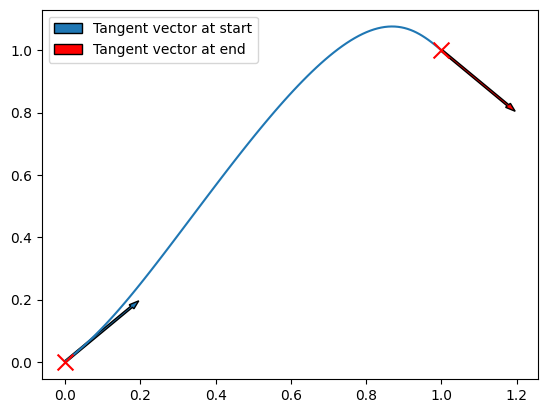

In [18]:
plt.scatter([0, 1], [0, 1], color='red', marker='x', s=130, zorder=10)

t = np.linspace(0, 1, 100)
x = 0.7071*t + 2.9289*t**3 - 4.3934*t**4 + 1.7574*t**5
y = 0.7071*t + 8.5858*t**3 - 14.2929*t**4 + 6.0*t**5
plt.plot(x, y)

# plot the tangent vectors
plt.arrow(0.0, 0.0, 0.1767, 0.1767, width=0.006, label='Tangent vector at start')
plt.arrow(1.0, 1.0, 0.1767, -0.1767, width=0.006, label='Tangent vector at end', fc='red')
plt.legend()
plt.show()

By specifying the two knots as well as the first and second derivative vectors we can uniquely solve for a segment.   
Let's see how:   
First, the segment must start at the first knot: $ \varphi(0) = (x_0, y_0) $   
Then, the segment must end at the second knot: $ \varphi(1) = (x_1, y_1) $   
Finally we introduce the first and second derivatives: $ \varphi'(0) = (x'_0, y'_0) \ \ \ , \varphi''(0) = (0, 0) $   
and $ \varphi'(1) = (x'_1, y'_1) \ \ \ , \varphi''(1) = (x''_0, y''_0) $   
For now, we set the second derivative vector at the knots to (0,0), so $x''_0 = x''_1 = y''_0 = y''_1 = 0$.   
Based on the definition of $ \varphi(t) $ we obtain two systems of linear equations, written in matrix notation as follows:
$$
\begin{bmatrix}
    0 & 0 & 0 & 0 & 0 & 1 \\
    0 & 0 & 0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 2 & 0 & 0 \\
    1 & 1 & 1 & 1 & 1 & 1 \\
    5 & 4 & 3 & 2 & 1 & 0 \\
    20 & 12 & 6 & 2 & 0 & 0 \\
\end{bmatrix}
\begin{bmatrix}
a_x\\ 
b_x\\ 
c_x\\ 
d_x\\ 
e_x\\ 
f_x
\end{bmatrix} =
\begin{bmatrix}
x_0\\ 
x'_0\\ 
x''_0 \\ 
x_1\\ 
x'_1\\ 
x''_1
\end{bmatrix}
\ and \ 
\begin{bmatrix}
    0 & 0 & 0 & 0 & 0 & 1 \\
    0 & 0 & 0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 2 & 0 & 0 \\
    1 & 1 & 1 & 1 & 1 & 1 \\
    5 & 4 & 3 & 2 & 1 & 0 \\
    20 & 12 & 6 & 2 & 0 & 0 \\
\end{bmatrix}
\begin{bmatrix}
a_y\\ 
b_y\\ 
c_y\\ 
d_y\\ 
e_y\\ 
f_y
\end{bmatrix} =
\begin{bmatrix}
y_0\\ 
y'_0\\ 
y''_0 \\ 
y_1\\ 
y'_1\\ 
y''_1
\end{bmatrix}
$$

Let's look at an example. We have two knots at (0,0) and (1,1). I want the tangent vector of the first knot to be horizontal, so I will choose $x'_0 = 1, y'_0 = 0$ and the tangent of the second knot to be vertical, so $x'_0 = 0, y'_0 = 1$.

Tangent vector at first knot: (1.0 , 0.0)
Tangent vector at second knot: (0.0 , 1.0)


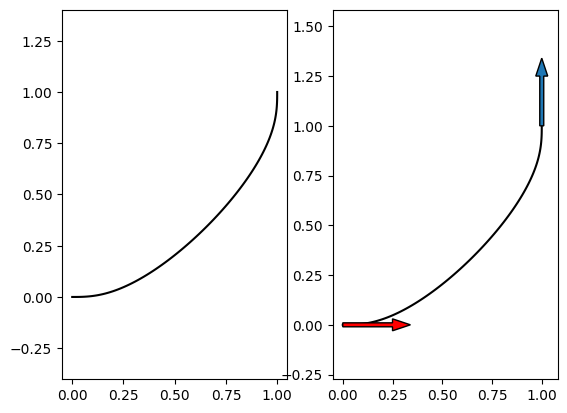

In [19]:
from scipy import linalg

fig, axis = plt.subplots(1, 2)

coefficient_matrix = [
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 2, 0, 0],
        [1, 1, 1, 1, 1, 1],
        [5, 4, 3, 2, 1, 0],
        [20, 12, 6, 2, 0, 0]
    ]

def compute_segment(knot1, knot2, xd, yd, xdd=[0,0], ydd=[0,0]):
    # Calculate the polynomial coefficients
    x_coeffs = linalg.solve(coefficient_matrix, [knot1[0], xd[0], xdd[0], knot2[0], xd[1], xdd[1]])
    y_coeffs = linalg.solve(coefficient_matrix, [knot1[1], yd[0], ydd[0], knot2[1], yd[1], ydd[1]])
    # Evaluate the polynomials
    t = np.linspace(0, 1, 100)
    x = x_coeffs[0]*t**5 + x_coeffs[1]*t**4 + x_coeffs[2]*t**3 + x_coeffs[3]*t**2 + x_coeffs[4]*t + x_coeffs[5]
    y = y_coeffs[0]*t**5 + y_coeffs[1]*t**4 + y_coeffs[2]*t**3 + y_coeffs[3]*t**2 + y_coeffs[4]*t + y_coeffs[5]
    return x_coeffs, y_coeffs, x, y

knot1 = [0, 0]
knot2 = [1, 1]
xd = [1, 0]
yd = [0, 1]
x_coeffs, y_coeffs, x, y = compute_segment(knot1, knot2, xd, yd)
axis[0].plot(x, y, color='black')
axis[0].set_ylim(-0.1, 1.4)
axis[0].axis('equal')

# Let's plot the tangent vectors to confirm our calculations
# We obtain them by calcutating phi'(0) and phi'(1) respectively
tangent_x_0 = x_coeffs[4]
tangent_y_0 = y_coeffs[4]
tangent_x_1 = 5*x_coeffs[0] + 4*x_coeffs[1] + 3*x_coeffs[2] + 2*x_coeffs[3] + x_coeffs[4]
tangent_y_1 = 5*y_coeffs[0] + 4*y_coeffs[1] + 3*y_coeffs[2] + 2*y_coeffs[3] + y_coeffs[4]
print('Tangent vector at first knot: ({} , {})'.format(tangent_x_0, tangent_y_0))
print('Tangent vector at second knot: ({} , {})'.format(tangent_x_1, tangent_y_1))
# tangents are scaled by 1/4 to fit in the figure nicely
axis[1].arrow(knot1[0], knot1[1], tangent_x_0 / 4, tangent_y_0 / 4, width=0.02, fc='red', zorder=10)
axis[1].arrow(knot2[0], knot2[1], tangent_x_1 / 4, tangent_y_1 / 4, width=0.02, zorder=10)
axis[1].plot(x, y, color='black')
axis[1].axis('equal')


plt.show()

The derivative vectors are in *cartesian form*, meaning we set the terminal point of each of the vectors. The length of the vectors also play an important role in the overall shape of the curve, not just its direction.   
In the example above, we set the tangent vectors to $(0,1)$ and $(1,0)$ respectively. Let's construct the same segment, but with the tangent vectors scaled by 1/4, so $(0, 0.25), (0.25, 0)$.

Tangent vector at first knot: (0.25 , 0.0)
Tangent vector at second knot: (3.552713678800501e-15 , 0.25000000000000355)


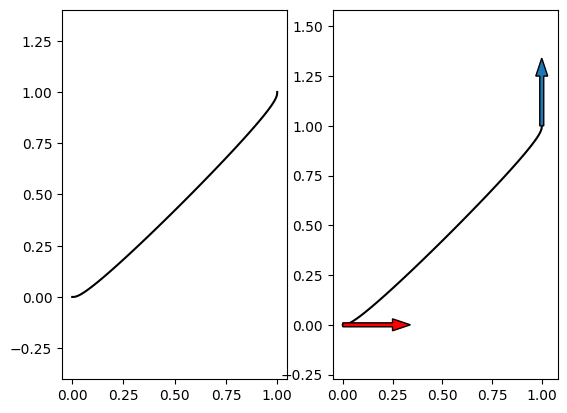

In [20]:
fig, axis = plt.subplots(1, 2)
knot1 = [0, 0]
knot2 = [1, 1]
xd = [0.25, 0]
yd = [0, 0.25]
x_coeffs, y_coeffs, x, y = compute_segment(knot1, knot2, xd, yd)
axis[0].plot(x, y, color='black')
axis[0].set_ylim(-0.1, 1.4)
axis[0].axis('equal')

tangent_x_0 = x_coeffs[4]
tangent_y_0 = y_coeffs[4]
tangent_x_1 = 5*x_coeffs[0] + 4*x_coeffs[1] + 3*x_coeffs[2] + 2*x_coeffs[3] + x_coeffs[4]
tangent_y_1 = 5*y_coeffs[0] + 4*y_coeffs[1] + 3*y_coeffs[2] + 2*y_coeffs[3] + y_coeffs[4]
print('Tangent vector at first knot: ({} , {})'.format(tangent_x_0, tangent_y_0))
print('Tangent vector at second knot: ({} , {})'.format(tangent_x_1, tangent_y_1))
# tangents are scaled by 1/4 to fit in the figure nicely
axis[1].arrow(knot1[0], knot1[1], tangent_x_0, tangent_y_0, width=0.02, fc='red', zorder=10)
axis[1].arrow(knot2[0], knot2[1], tangent_x_1, tangent_y_1 , width=0.02, zorder=10)
axis[1].plot(x, y, color='black')
axis[1].axis('equal')

plt.show()

It is clear how shorter tangent vectors means less curvature of the segment. Feel free to play around with the tangent vectors until everything is clear.

##### First derivative in polar coordinates

Instead of using the cartesian form of the tangent vectors, we can use **polar coordinates**. In this coordinate system, the terminal point of the vector is expressed as a distance from the origin and an angle with respect to the x axis.   
For example, the vector with its terminal point at $ (1,1) $ can be written in polar form as $ (45°, \sqrt{2}) $ meaning the vector forms a 45° angle with the x axis and has a magnitude of $ \sqrt{2}$.   
In general, a point $(x, y)$ is converted to polar coordinates as follows:
$$ x = r cos(\theta) \\  y = r sin(\theta) $$
where $r$ is the radius (distance from the origin) and $ \theta $ is the angle.   

Going back to our segment, it is easier to think of the tangent vector in polar coordinates, so let's implement that. We just take an extra step before we get to the linear system.

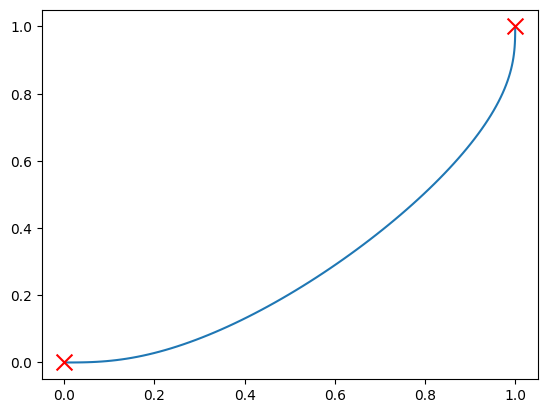

In [21]:
import math
knot1 = [0, 0]
knot2 = [1, 1]
plt.scatter(knot1[0], knot1[1], color='red', marker='x', s=130, zorder=10)
plt.scatter(knot2[0], knot2[1], color='red', marker='x', s=130, zorder=10)

start_angle = 0
start_radius = 1

end_angle = 90
end_radius = 1

xd = [start_radius * math.cos(math.radians(start_angle)), end_radius * math.cos(math.radians(end_angle))]
yd = [start_radius * math.sin(math.radians(start_angle)), end_radius * math.sin(math.radians(end_angle))]
__, __, x, y = compute_segment(knot1, knot2, xd, yd)
plt.plot(x, y)
plt.show()

Let's have a look at one final example to illustrate the flexibility of the segment.

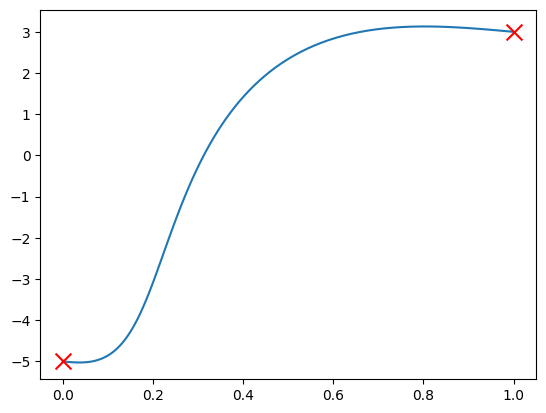

In [22]:
knot1 = [0, -5]
knot2 = [1, 3]

start_angle = -45
start_radius = 1

end_angle = -45
end_radius = 3

plt.scatter(knot1[0], knot1[1], color='red', marker='x', s=130, zorder=10)
plt.scatter(knot2[0], knot2[1], color='red', marker='x', s=130, zorder=10)

xd = [start_radius * math.cos(math.radians(start_angle)), end_radius * math.cos(math.radians(end_angle))]
yd = [start_radius * math.sin(math.radians(start_angle)), end_radius * math.sin(math.radians(end_angle))]
__, __, x, y = compute_segment(knot1, knot2, xd, yd)
plt.plot(x, y)
plt.show()

#### Creating the spline

Now that we know how to construct a single segment, we can tackle the creation of an entire spline.

TODO